# Plotting 

## Data Aggregation

In [35]:
import os
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from matplotlib.ticker import FuncFormatter


NUM_ITER = 1000
SCENE_NAME = "hotdog"
# WITH_OCC = True



In [36]:
# --- 1. Data Collection and Aggregation ---

# Input directory containing the JSON files
input_dir = Path('output/1031_distortion/hotdog/for_plot')
# Output directory for aggregated JSONs and plots
output_dir = Path('output/1031_distortion/hotdog/plots')
output_dir.mkdir(parents=True, exist_ok=True)

files = sorted(glob(str(input_dir / '*.json')))
# policy -> list of {num_gs, psnr, ssim, lpips}
policy_data = defaultdict(list)

print(f"Found {len(files)} files in {input_dir}")

for fp in files:
    try:
        # Extract policy and budget from filename like 'distortion_131072_occlusion.json'
        basename = os.path.basename(fp)
        stem = Path(basename).stem
        parts = stem.split('_')

        if "no_occlusion" in stem:
            # e.g., uniform_131072_no_occlusion
            policy_base = '_'.join(parts[:-3])
            budget_str = parts[-3]
            policy = f"{policy_base}_no_occ"
        else:
            # e.g., distortion_131072_occlusion
            policy_base = '_'.join(parts[:-2])
            budget_str = parts[-2]
            policy = f"{policy_base}_occ"

        num_gs = int(budget_str)

        with open(fp, 'r') as f:
            data = json.load(f)
        
        # The JSON has a structure like {"key": {"metric": value, ...}}
        # We get the first value from the top-level dictionary
        metrics = list(data.values())[0]
        
        psnr = metrics.get('PSNR')
        ssim = metrics.get('SSIM')
        lpips = metrics.get('LPIPS')

        if all(v is not None for v in [psnr, ssim, lpips]):
            policy_data[policy].append({
                "policy_name": policy,
                "num_gs": num_gs,
                "psnr": float(psnr),
                "ssim": float(ssim),
                "lpips": float(lpips)
            })
        else:
            print(f"Skipping {fp}: Missing one or more metrics.")

    except Exception as e:
        print(f"Error processing {fp}: {e}")

# --- 2. Save Aggregated Data to JSON Files ---

policies = sorted(policy_data.keys())
print(f"\nFound policies: {policies}")

for policy in policies:
    # Sort data by num_gs before saving
    sorted_data = sorted(policy_data[policy], key=lambda x: x['num_gs'])
    output_json_path = output_dir / f'{policy}_aggregated.json'
    with open(output_json_path, 'w') as f:
        json.dump(sorted_data, f, indent=2)
    print(f"Saved aggregated data to {output_json_path}")
    
# example shape
example_shape = (len(policy_data[policies[0]]),)
print(f"Example shape of aggregated data for policy '{policies[0]}': {example_shape}")


Found 18 files in output/1031_distortion/hotdog/for_plot

Found policies: ['distortion_occ', 'uniform_no_occ', 'uniform_occ']
Saved aggregated data to output/1031_distortion/hotdog/plots/distortion_occ_aggregated.json
Saved aggregated data to output/1031_distortion/hotdog/plots/uniform_no_occ_aggregated.json
Saved aggregated data to output/1031_distortion/hotdog/plots/uniform_occ_aggregated.json
Example shape of aggregated data for policy 'distortion_occ': (8,)


## Policy Comparison Charts

In [37]:

# # 1028 experiment
# WITH_OCC = False 
# aggregated_json_path = Path('output/exp1028_plots/')


# 1027 experiment
WITH_OCC = True 
aggregated_json_path = Path('output/with_occ_json')



In [38]:

# [TODO] keep a fixed y-min (e.g. 26dB) across plots for policies, for better comparison
def autoset_ylim(ax, metric_key: str, values: 'list[float]') -> None:
    lo = min(values)
    hi = max(values)
    rng = max(hi - lo, 1e-9) 

    if metric_key.upper() == "PSNR":
        pad = max(0.15 * rng, 0.3)           # PSNR in dB 
        ax.set_ylim(lo - pad, hi + pad)

    elif metric_key.upper() == "SSIM":
        pad = max(0.25 * rng, 0.005)         # SSIM [0,1]
        ax.set_ylim(max(0.85, lo - pad), min(1.0, hi + pad))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))

    elif metric_key.upper() == "LPIPS":
        pad = max(0.25 * rng, 0.01)          # LPIPS [0,1]
        ax.set_ylim(max(0.0, lo - pad), min(0.6, hi + pad))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))


def plot_metrics(policy_data, scene_name, num_iter, output_dir, draw_log_scale=False):
    """
    Generates and saves plots for PSNR, SSIM, and LPIPS vs. Number of Gaussians.

    Args:
        policy_data (dict): A dictionary where keys are policy names and values are lists of metric records.
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        output_dir (Path): The directory to save the plots.
        draw_log_scale (bool): Whether to use a log scale for the x-axis.
    """
    policies = sorted(policy_data.keys())
    
    metrics_to_plot = {
        "PSNR": {"unit": "dB", "label": "PSNR (Test) [dB]"},
        "SSIM": {"unit": "", "label": "SSIM (Test)"},
        "LPIPS": {"unit": "", "label": "LPIPS (Test)"}
    }
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(policies)))

    for metric_key, metric_info in metrics_to_plot.items():
        fig, ax = plt.subplots(figsize=(8, 5))
        
        for policy, color in zip(policies, colors):
            records = policy_data.get(policy, [])
            if not records:
                continue

            # Sort by num_gs to ensure lines are drawn correctly
            records.sort(key=lambda r: r['num_gs'])
            
            xs = np.array([r['num_gs'] for r in records])
            ys = np.array([r[metric_key.lower()] for r in records])
            
            # Ensure positive x values for log scale
            xs_plot = np.maximum(xs, 1)
            
            marker = 'o'
            
            ax.plot(xs_plot, ys, marker=marker, linestyle='-', linewidth=2, markersize=5, 
                    color=color, label=policy.replace('_', ' ').title())
        
        
        ax.set_ylabel(metric_info["label"])
        fig.suptitle(f'{metric_key} vs. Number of Gaussians by Policy')
        ax.set_title(f'{scene_name} | NUM_ITER={num_iter} | WITH_DEPTH={WITH_OCC}', fontsize='small')
        
        ax.set_xlabel('#Gaussians')
        
        if draw_log_scale:
            try:
                ax.set_xscale('log', base=2)
                ax.set_xlabel('#Gaussians (log2 scale)')
            except TypeError:
                ax.set_xscale('log', basex=2)  # Fallback for older Matplotlib
        
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.legend(title='Policy')
        plt.tight_layout()
        
        # Save figure
        output_fig_path = output_dir / f'{metric_key.lower()}_vs_numgs_line_chart.png'
        plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
        print(f"\nFigure saved to {output_fig_path}")
        
        plt.show()


### result


Loading aggregated data from directory: output/with_occ_json
  Loaded data for policy 'area'
  Loaded data for policy 'planarity'
  Loaded data for policy 'random'
  Loaded data for policy 'uniform'

Figure saved to output/with_occ_json/psnr_vs_numgs_line_chart.png


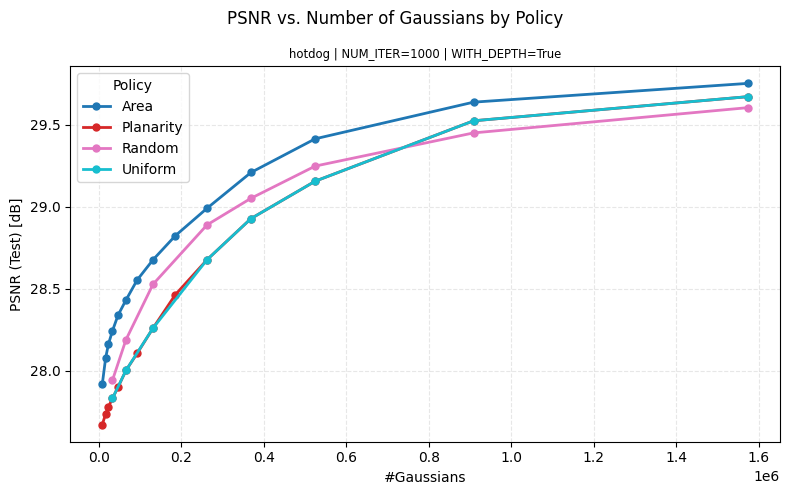


Figure saved to output/with_occ_json/ssim_vs_numgs_line_chart.png


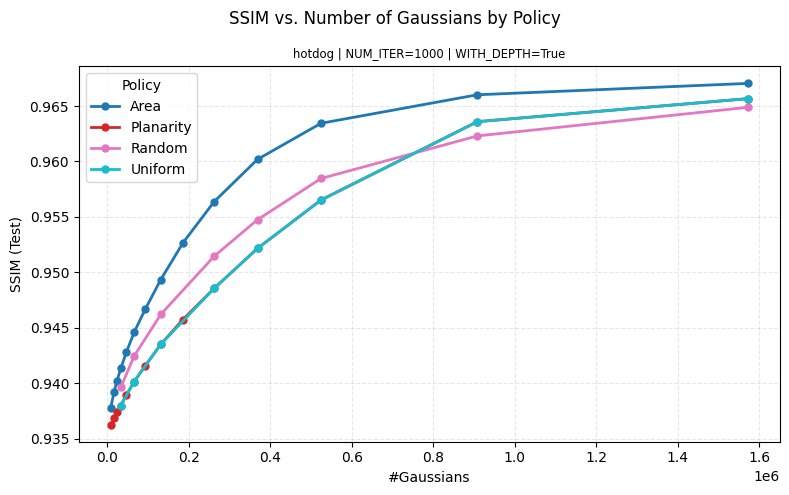


Figure saved to output/with_occ_json/lpips_vs_numgs_line_chart.png


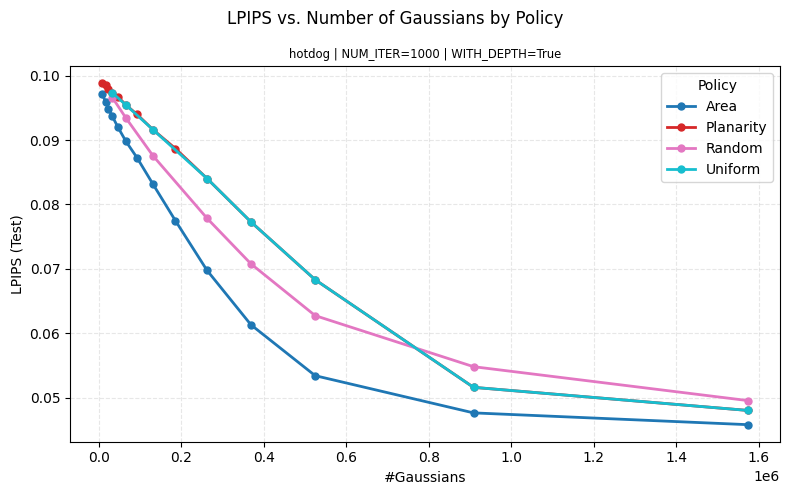

In [39]:
""" 3. Plotting """


# --- Plotting Logic ---

if aggregated_json_path and aggregated_json_path.is_dir():
    print(f"Loading aggregated data from directory: {aggregated_json_path}")
    data_to_plot = defaultdict(list)
    json_files = sorted(glob(str(aggregated_json_path / '*_aggregated.json')))
    
    if not json_files:
        print(f"No '*_aggregated.json' files found in {aggregated_json_path}")
        data_to_plot = None
    else:
        for file_path in json_files:
            try:
                policy_name = Path(file_path).name.replace('_aggregated.json', '')
                with open(file_path, 'r') as f:
                    loaded_data = json.load(f)
                
                if loaded_data:
                    data_to_plot[policy_name] = loaded_data
                    print(f"  Loaded data for policy '{policy_name}'")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        output_dir = aggregated_json_path

elif 'policy_data' in locals() and policy_data:
    print("Using aggregated data from the previous cell.")
    data_to_plot = policy_data

if data_to_plot:
    plot_metrics(
        policy_data=data_to_plot,
        scene_name=SCENE_NAME,
        num_iter=NUM_ITER,
        output_dir=output_dir,
        draw_log_scale=False
    )
else:
    print("\nNo data found to plot!")

## Occlusion Comparison Charts
compare rasterization with/without occlusion considered.


In [40]:


def plot_comparison_difference_line_chart(occ_data, vanilla_data, scene_name, num_iter, output_dir, draw_log_scale=False):
    """
    Generates line charts showing the difference (OCC - Vanilla) for each metric across all budgets.
    
    Args:
        occ_data (dict): Policy data with OCC enabled.
        vanilla_data (dict): Policy data without OCC.
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        output_dir (Path): The directory to save the plots.
    """
    # Find common policies
    common_policies = sorted(set(occ_data.keys()) & set(vanilla_data.keys()))
    
    if not common_policies:
        print("No common policies found!")
        return
    
    metrics_to_plot = {
        "PSNR": {"label": "PSNR Difference (With OCC - Without OCC) [dB]"},
        "SSIM": {"label": "SSIM Difference (With OCC - Without OCC)"},
        "LPIPS": {"label": "LPIPS Difference (With OCC - Without OCC)"}
    }
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(common_policies)))

    for metric_key, metric_info in metrics_to_plot.items():
        fig, ax = plt.subplots(figsize=(12, 7))
        
        for policy, color in zip(common_policies, colors):
            occ_records = sorted(occ_data.get(policy, []), key=lambda r: r['num_gs'])
            vanilla_records = sorted(vanilla_data.get(policy, []), key=lambda r: r['num_gs'])
            
            # Create dictionaries for quick lookup
            occ_budgets = {r['num_gs']: r[metric_key.lower()] for r in occ_records}
            vanilla_budgets = {r['num_gs']: r[metric_key.lower()] for r in vanilla_records}
            
            common_budgets = sorted(set(occ_budgets.keys()) & set(vanilla_budgets.keys()))
            
            if not common_budgets:
                continue
            
            # Calculate differences
            differences = [occ_budgets[b] - vanilla_budgets[b] for b in common_budgets]
            
            # Plotting
            ax.plot(common_budgets, differences, marker='o', linestyle='-', 
                    label=policy.replace('_', ' ').title(), color=color)

        # Add a horizontal line at y=0 for reference
        ax.axhline(0, color='grey', linestyle='--', linewidth=1)
        
        # Customize plot
        ax.set_ylabel(metric_info["label"], fontsize=12)
        ax.set_xlabel('#Gaussians', fontsize=12)
        fig.suptitle(f'{metric_key} Difference: DTGS vs. TGS', fontsize=14, fontweight='bold')
        ax.set_title(f'{scene_name} | NUM_ITER={num_iter} | D = Depth, T = Texture', fontsize=10)
        
        
        if draw_log_scale:
            try:
                ax.set_xscale('log', base=2)
                ax.set_xlabel('#Gaussians (log2 scale)')
            except TypeError:
                ax.set_xscale('log', basex=2)  # Fallback for older Matplotlib
        
        
        # 
        # ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
        
        ax.legend(title='Policy', loc='best')
        ax.grid(True, which="both", ls="--", alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        output_fig_path = output_dir / f'{metric_key.lower()}_difference_line_chart.png'
        plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
        print(f"Figure saved to {output_fig_path}")
        
        plt.show()




### result

Loaded OCC data for policy 'area'
Loaded OCC data for policy 'planarity'
Loaded OCC data for policy 'random'
Loaded OCC data for policy 'uniform'
Loaded vanilla data for policy 'area'
Loaded vanilla data for policy 'planarity'
Loaded vanilla data for policy 'random'
Loaded vanilla data for policy 'uniform'

--- Plotting difference line chart ---


Figure saved to output/1031_plot_results/psnr_difference_line_chart.png


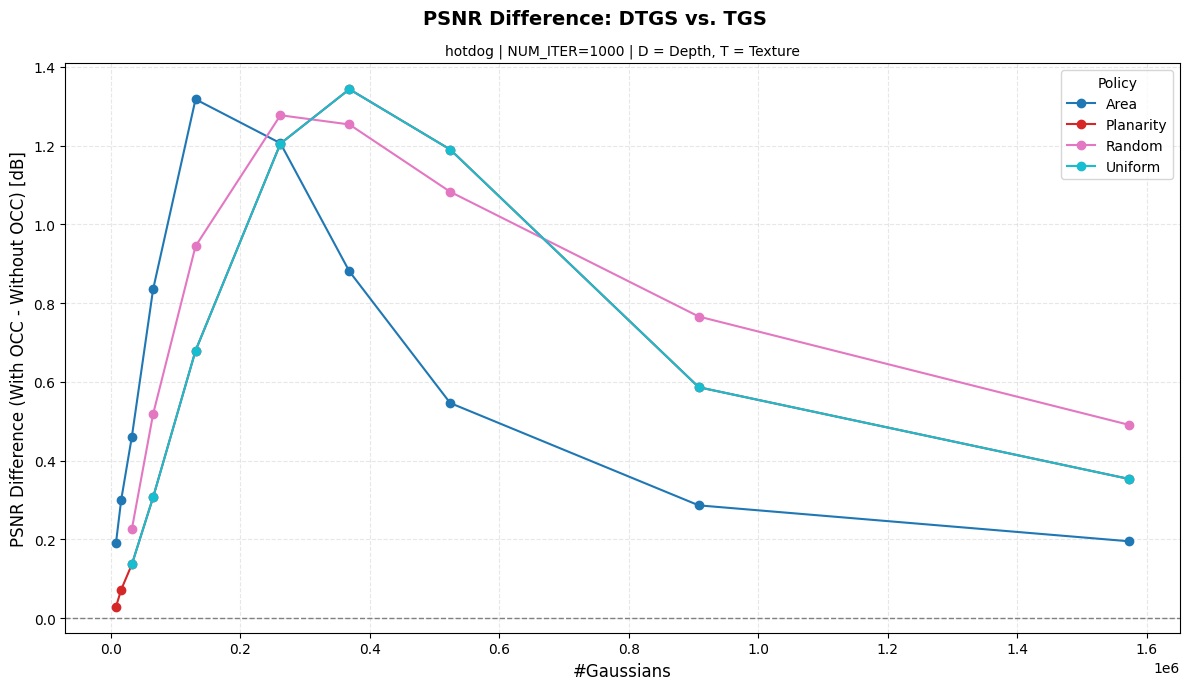

Figure saved to output/1031_plot_results/ssim_difference_line_chart.png


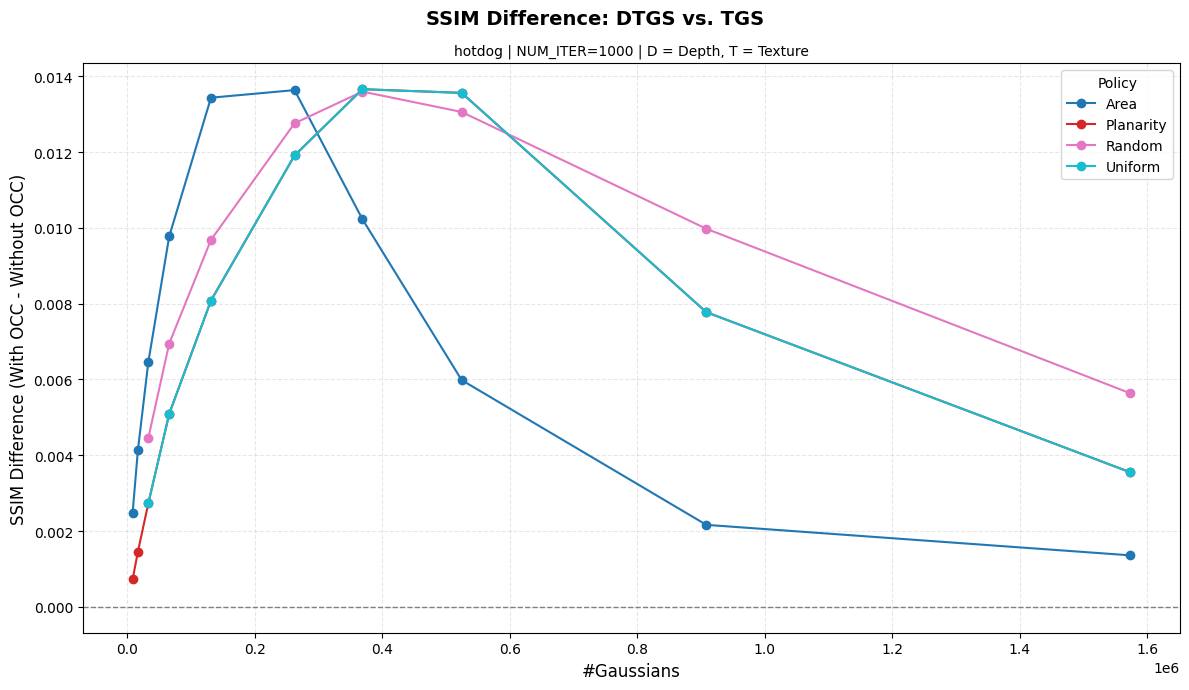

Figure saved to output/1031_plot_results/lpips_difference_line_chart.png


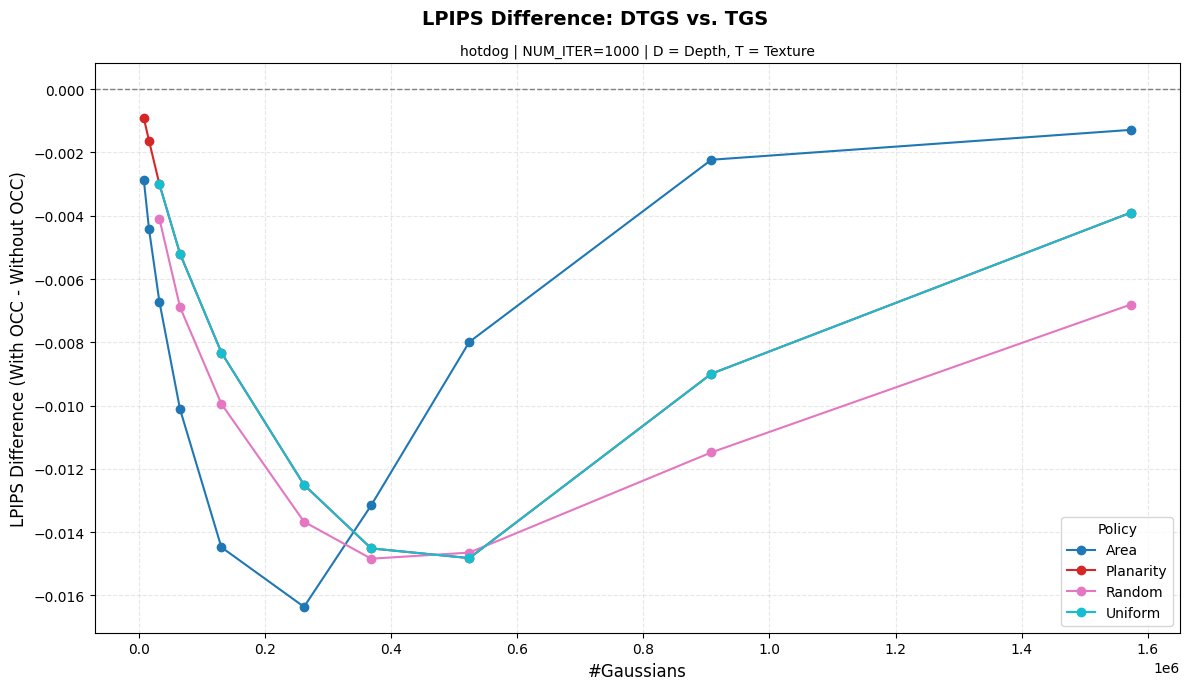

In [41]:


occ_json_path = Path('output/with_occ_json/')
vanila_json_path = Path('output/without_occ_json/')

""" Load data and plot comparisons """

# Load OCC data
occ_data_dict = defaultdict(list)
occ_json_files = sorted(glob(str(occ_json_path / '*_aggregated.json')))
for file_path in occ_json_files:
    policy_name = Path(file_path).name.replace('_aggregated.json', '')
    with open(file_path, 'r') as f:
        occ_data_dict[policy_name] = json.load(f)
    print(f"Loaded OCC data for policy '{policy_name}'")

# Load vanilla data
vanilla_data_dict = defaultdict(list)
vanilla_json_files = sorted(glob(str(vanila_json_path / '*_aggregated.json')))
for file_path in vanilla_json_files:
    policy_name = Path(file_path).name.replace('_aggregated.json', '')
    with open(file_path, 'r') as f:
        vanilla_data_dict[policy_name] = json.load(f)
    print(f"Loaded vanilla data for policy '{policy_name}'")

# Create output directory for comparison plots
comparison_output_dir = Path('output/1031_plot_results/')
comparison_output_dir.mkdir(parents=True, exist_ok=True)



# Plot comparison as a difference line chart
print("\n--- Plotting difference line chart ---")
plot_comparison_difference_line_chart(
    occ_data=occ_data_dict,
    vanilla_data=vanilla_data_dict,
    scene_name=SCENE_NAME,
    num_iter=NUM_ITER,
    output_dir=comparison_output_dir
)



# Entropy Image

In [42]:
from skimage import io, color
from skimage.filters import rank
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np

# load image and convert to grayscale, 8-bit
img = io.imread("data/dynerf/test_yc_mesh/mesh_000.png")

# Check if the image has an alpha channel (4 channels) and remove it if present
if img.shape[-1] == 4:
    img = img[..., :3]

gray = color.rgb2gray(img)
gray_ubyte = (gray * 255).astype(np.uint8)

# compute local entropy with a disk-shaped neighborhood
entropy_img = rank.entropy(gray_ubyte, disk(5))
# disk() value can be adjusted

# overall complexity score = mean entropy
complexity = np.mean(entropy_img)
print("Spatial complexity (entropy):", complexity)

# show result
plt.imshow(entropy_img, cmap="magma")
plt.colorbar()
plt.show()

ModuleNotFoundError: No module named 'skimage'